# Predicting Boston Housing Prices

## Getting Started
In this project, you will evaluate the performance and predictive power of a model that has been trained and tested on data collected from homes in suburbs of Boston, Massachusetts. A model trained on this data that is seen as a *good fit* could then be used to make certain predictions about a home — in particular, its monetary value. This model would prove to be invaluable for someone like a real estate agent who could make use of such information on a daily basis.

The dataset for this project originates from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Housing). The Boston housing data was collected in 1978 and each of the 506 entries represent aggregated data about 14 features for homes from various suburbs in Boston, Massachusetts. For the purposes of this project, the following preprocessing steps have been made to the dataset:
- 16 data points have an `'MEDV'` value of 50.0. These data points likely contain **missing or censored values** and have been removed.
- 1 data point has an `'RM'` value of 8.78. This data point can be considered an **outlier** and has been removed.
- The features `'RM'`, `'LSTAT'`, `'PTRATIO'`, and `'MEDV'` are essential. The remaining **non-relevant features** have been excluded.
- The feature `'MEDV'` has been **multiplicatively scaled** to account for 35 years of market inflation.

Run the code cell below to load the Boston housing dataset, along with a few of the necessary Python libraries required for this project. You will know the dataset loaded successfully if the size of the dataset is reported.

In [8]:
import sklearn
print(sklearn.__version__)

1.5.2


In [9]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, make_scorer
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV

import seaborn as sns
from matplotlib import pyplot as plt

# Pretty display for notebooks
%matplotlib inline

# Load the Boston housing dataset
data = pd.read_csv('input/housing.csv')
prices = data['MEDV']
features = data.drop('MEDV', axis = 1)

# Success
print("Boston housing dataset has {} data points with {} variables each.".format(*data.shape))


Boston housing dataset has 489 data points with 4 variables each.


In [10]:
# Check for data types and Null values
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 489 entries, 0 to 488
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   RM       489 non-null    float64
 1   LSTAT    489 non-null    float64
 2   PTRATIO  489 non-null    float64
 3   MEDV     489 non-null    float64
dtypes: float64(4)
memory usage: 15.4 KB


In [11]:
data.describe()

,RM,LSTAT,PTRATIO,MEDV
count,489.000000,489.000000,489.000000,4.890000e+02
mean,6.240288,12.939632,18.516564,4.543429e+05
std,0.643650,7.081990,2.111268,1.653403e+05
min,3.561000,1.980000,12.600000,1.050000e+05
25%,5.880000,7.370000,17.400000,3.507000e+05
50%,6.185000,11.690000,19.100000,4.389000e+05
75%,6.575000,17.120000,20.200000,5.187000e+05
max,8.398000,37.970000,22.000000,1.024800e+06


## Visualization Code

In [12]:
###########################################
# Suppress matplotlib user warnings
# Necessary for newer version of matplotlib
import warnings
warnings.filterwarnings("ignore", category = UserWarning, module = "matplotlib")
#
# Display inline matplotlib plots with IPython
from IPython import get_ipython
get_ipython().run_line_magic('matplotlib', 'inline')
###########################################

import matplotlib.pyplot as pl
import numpy as np
from sklearn.model_selection import learning_curve
from sklearn.model_selection import validation_curve
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import ShuffleSplit, train_test_split

def ModelLearning(X, y):
    """ Calculates the performance of several models with varying sizes of training data.
        The learning and testing scores for each model are then plotted. """
    
    # Create 10 cross-validation sets for training and testing
    cv = ShuffleSplit(n_splits = 10, test_size = 0.2, random_state = 0)
    cv.get_n_splits(X)

    # Generate the training set sizes increasing by 50
    train_sizes = np.rint(np.linspace(1, X.shape[0]*0.8 - 1, 9)).astype(int)

    # Create the figure window
    fig = pl.figure(figsize=(10,7))

    # Create three different models based on max_depth
    for k, depth in enumerate([1,3,6,10]):
        
        # Create a Decision tree regressor at max_depth = depth
        regressor = DecisionTreeRegressor(max_depth = depth)

        # Calculate the training and testing scores
        sizes, train_scores, test_scores = learning_curve(regressor, X, y, \
            cv = cv, train_sizes = train_sizes, scoring = 'r2')
        
        # Find the mean and standard deviation for smoothing
        train_std = np.std(train_scores, axis = 1)
        train_mean = np.mean(train_scores, axis = 1)
        test_std = np.std(test_scores, axis = 1)
        test_mean = np.mean(test_scores, axis = 1)

        # Subplot the learning curve 
        ax = fig.add_subplot(2, 2, k+1)
        ax.plot(sizes, train_mean, 'o-', color = 'r', label = 'Training Score')
        ax.plot(sizes, test_mean, 'o-', color = 'g', label = 'Testing Score')
        ax.fill_between(sizes, train_mean - train_std, \
            train_mean + train_std, alpha = 0.15, color = 'r')
        ax.fill_between(sizes, test_mean - test_std, \
            test_mean + test_std, alpha = 0.15, color = 'g')
        
        # Labels
        ax.set_title('max_depth = %s'%(depth))
        ax.set_xlabel('Number of Training Points')
        ax.set_ylabel('Score')
        ax.set_xlim([0, X.shape[0]*0.8])
        ax.set_ylim([-0.05, 1.05])
    
    # Visual aesthetics
    ax.legend(bbox_to_anchor=(1.05, 2.05), loc='lower left', borderaxespad = 0.)
    fig.suptitle('Decision Tree Regressor Learning Performances', fontsize = 16, y = 1.03)
    fig.tight_layout()
    fig.show()


def ModelComplexity(X, y):
    """ Calculates the performance of the model as model complexity increases.
        The learning and testing errors rates are then plotted. """
    
    # Create 10 cross-validation sets for training and testing
    cv = ShuffleSplit(n_splits = 10, test_size = 0.2, random_state = 0)
    cv.get_n_splits(X)

    # Vary the max_depth parameter from 1 to 10
    max_depth = np.arange(1,11)

    # Calculate the training and testing scores
    train_scores, test_scores = validation_curve(DecisionTreeRegressor(), X, y, \
        param_name = "max_depth", param_range = max_depth, cv = cv, scoring = 'r2')

    # Find the mean and standard deviation for smoothing
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    # Plot the validation curve
    pl.figure(figsize=(7, 5))
    pl.title('Decision Tree Regressor Complexity Performance')
    pl.plot(max_depth, train_mean, 'o-', color = 'r', label = 'Training Score')
    pl.plot(max_depth, test_mean, 'o-', color = 'g', label = 'Validation Score')
    pl.fill_between(max_depth, train_mean - train_std, \
        train_mean + train_std, alpha = 0.15, color = 'r')
    pl.fill_between(max_depth, test_mean - test_std, \
        test_mean + test_std, alpha = 0.15, color = 'g')
    
    # Visual aesthetics
    pl.legend(loc = 'lower right')
    pl.xlabel('Maximum Depth')
    pl.ylabel('Score')
    pl.ylim([-0.05,1.05])
    pl.show()


def PredictTrials(X, y, fitter, data):
    """ Performs trials of fitting and predicting data. """

    # Store the predicted prices
    prices = []

    for k in range(10):
        # Split the data
        X_train, X_test, y_train, y_test = train_test_split(X, y, \
            test_size = 0.2, random_state = k)
        
        # Fit the data
        reg = fitter(X_train, y_train)
        
        # Make a prediction
        pred = reg.predict([data[0]])[0]
        prices.append(pred)
        
        # Result
        print("Trial {}: ${:,.2f}".format(k+1, pred))

    # Display price range
    print("\nRange in prices: ${:,.2f}".format(max(prices) - min(prices)))

## Data Exploration
In this first section of this project, you will make a cursory investigation about the Boston housing data and provide your observations. Familiarizing yourself with the data through an explorative process is a fundamental practice to help you better understand and justify your results.

Since the main goal of this project is to construct a working model which has the capability of predicting the value of houses, we will need to separate the dataset into **features (Independent Variables)** and the **target variable (Dependent Varaibale)**. The **features**, `'RM'`, `'LSTAT'`, and `'PTRATIO'`, give us quantitative information about each data point. The **target variable**, `'MEDV'`, will be the variable we seek to predict. These are stored in `features` and `prices`, respectively.

### Implementation: Calculate Statistics
For your very first coding implementation, you will calculate descriptive statistics about the Boston housing prices. Since `numpy` has already been imported for you, use this library to perform the necessary calculations. These statistics will be extremely important later on to analyze various prediction results from the constructed model.

In the code cell below, you will need to implement the following:
- Calculate the minimum, maximum, mean, median, and standard deviation of `'MEDV'`, which is stored in `prices`.
  - Store each calculation in their respective variable.

In [13]:
# Minimum price of the data
minimum_price = np.min(prices)

# Maximum price of the data
maximum_price = np.max(prices)

# Mean price of the data
mean_price = np.mean(prices)

# Median price of the data
median_price = np.median(prices)

# Standard deviation of prices of the data
std_price = np.std(prices)

# Show the calculated statistics
print("Statistics for Boston housing dataset:\n")
print("Minimum price: ${:,.2f}".format(minimum_price))
print("Maximum price: ${:,.2f}".format(maximum_price))
print("Mean price: ${:,.2f}".format(mean_price))
print("Median price ${:,.2f}".format(median_price))
print("Standard deviation of prices: ${:,.2f}".format(std_price))

Statistics for Boston housing dataset:

Minimum price: $105,000.00
Maximum price: $1,024,800.00
Mean price: $454,342.94
Median price $438,900.00
Standard deviation of prices: $165,171.13


In [14]:
with pd.option_context('float_format', '{:.2f}'.format):
    print(prices.describe())

count       489.00
mean     454342.94
std      165340.28
min      105000.00
25%      350700.00
50%      438900.00
75%      518700.00
max     1024800.00
Name: MEDV, dtype: float64


### Question 1 - Feature Observation
As a reminder, we are using three features from the Boston housing dataset: `'RM'`, `'LSTAT'`, and `'PTRATIO'`. For each data point (neighborhood):
- `'RM'` is the average number of rooms among homes in the neighborhood.
- `'LSTAT'` is the percentage of homeowners in the neighborhood considered "lower class" (working poor).
- `'PTRATIO'` is the ratio of students to teachers in primary and secondary schools in the neighborhood.


** Using your intuition, for each of the three features above, do you think that an increase in the value of that feature would lead to an **increase** in the value of `'MEDV'` or a **decrease** in the value of `'MEDV'`? Justify your answer for each.**

**Hint:** This problem can phrased using examples like below.  
* Would you expect a home that has an `'RM'` value(number of rooms) of 6 be worth more or less than a home that has an `'RM'` value of 7?
* Would you expect a neighborhood that has an `'LSTAT'` value(percent of lower class workers) of 15 have home prices be worth more or less than a neighborhood that has an `'LSTAT'` value of 20?
* Would you expect a neighborhood that has an `'PTRATIO'` value(ratio of students to teachers) of 10 have home prices be worth more or less than a neighborhood that has an `'PTRATIO'` value of 15?

**Answer: **

1. _Would you expect a home that has an `'RM'` value(number of rooms) of 6 be worth more or less than a home that has an `'RM'` value of 7?_ - As the number of rooms increases, in most of the cases, the Floor Area increases which in-turn increases the price of the house. So, a house that has an `'RM'` value(number of rooms) of 6 will have a lesser worth than a home that has an `'RM'` value of 7. (`'RM` vs `'Price'` is a Positive Correlation)
2. _Would you expect a neighborhood that has an `'LSTAT'` value(percent of lower class workers) of 15 have home prices be worth more or less than a neighborhood that has an `'LSTAT'` value of 20?_ - Usually, high-class socities tend to have a higher home prices. So, as the percent of lower class workers decreases, the price of the house will increase. In this case, a neighborhood that has an `'LSTAT'` value(percent of lower class workers) of 15 have home prices worth more than a neighborhood that has an `'LSTAT'` value of 20. (`'LSTAT'` vs `'Price'` is a Negative Correlation)
3. _Would you expect a neighborhood that has an `'PTRATIO'` value(ratio of students to teachers) of 10 have home prices be worth more or less than a neighborhood that has an `'PTRATIO'` value of 15?_ - Usually, the ratio of teachers to students will be less in good schools and these good schools are mostly located in high class neighbours which have houses of high price. So, in our case a neighborhood that has an `'PTRATIO'` value(ratio of students to teachers) of 10 have home prices be worth more than a neighborhood that has an `'PTRATIO'` value of 15. (`'PTRATIO'` vs `'Price'` is a Negative Correlation)

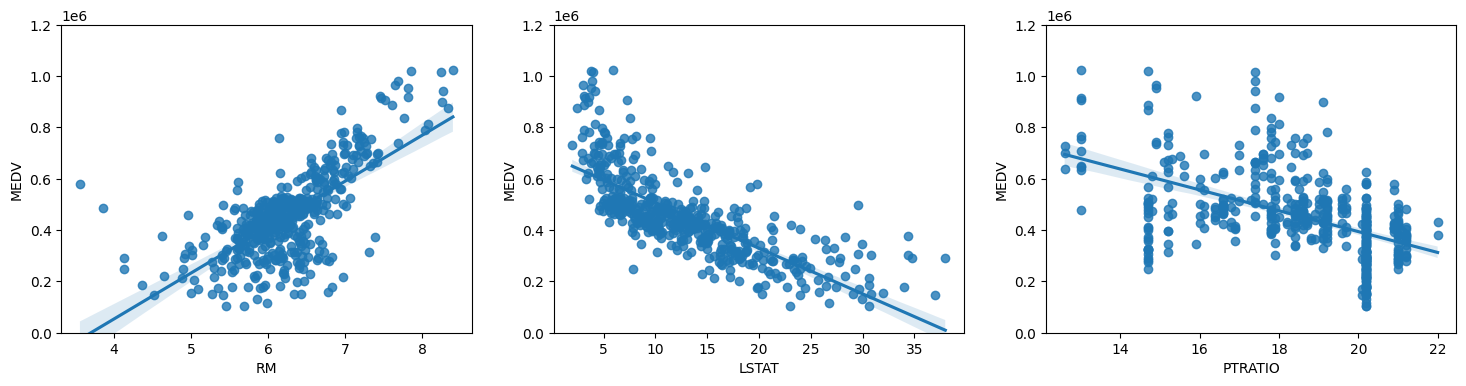

In [15]:
fig, axs = plt.subplots(ncols=3, figsize=(18,4))

for i in range(len(axs)):
    axs[i].set_ylim([0, 1200000])
# RM vs Price
_ = sns.regplot(x=features['RM'], y=prices, ax=axs[0])
# LSSAT vs Price
_ = sns.regplot(x=features['LSTAT'], y=prices, ax=axs[1])
# PTRATIO vs Price
_ = sns.regplot(x=features['PTRATIO'], y=prices, ax=axs[2])

plt.show()

----

## Developing a Model

In this second section of the project, we will develop the tools and techniques necessary for a model to make a prediction. Being able to make accurate evaluations of each model's performance through the use of these tools and techniques helps to greatly reinforce the confidence in your predictions.

### Implementation: Define a Performance Metric
It is difficult to measure the quality of a given model without quantifying its performance over training and testing. This is typically done using some type of performance metric, whether it is through calculating some type of error, the goodness of fit, or some other useful measurement. For this project, you will be calculating the [*coefficient of determination*](http://stattrek.com/statistics/dictionary.aspx?definition=coefficient_of_determination), R<sup>2</sup>, to quantify your model's performance. The coefficient of determination for a model is a useful statistic in regression analysis, as it often describes how "good" that model is at making predictions. 

The values for R<sup>2</sup> range from 0 to 1, which captures the percentage of squared correlation between the predicted and actual values of the **target variable**. A model with an R<sup>2</sup> of 0 is no better than a model that always predicts the *mean* of the target variable, whereas a model with an R<sup>2</sup> of 1 perfectly predicts the target variable. Any value between 0 and 1 indicates what percentage of the target variable, using this model, can be explained by the **features**. _A model can be given a negative R<sup>2</sup> as well, which indicates that the model is **arbitrarily worse** than one that always predicts the mean of the target variable._

For the `performance_metric` function in the code cell below, you will need to implement the following:
- Use `r2_score` from `sklearn.metrics` to perform a performance calculation between `y_true` and `y_predict`.
- Assign the performance score to the `score` variable.

In [16]:
def performance_metric(y_true, y_predict):
    """ Calculates and returns the performance score between 
        true and predicted values based on the metric chosen. """
    
    # Calculate the performance score between 'y_true' and 'y_predict'
    score = r2_score(y_true, y_predict)
    
    # Return the score
    return score

### Question 2 - Goodness of Fit
Assume that a dataset contains five data points and a model made the following predictions for the target variable:

| True Value | Prediction |
| :-------------: | :--------: |
| 3.0 | 2.5 |
| -0.5 | 0.0 |
| 2.0 | 2.1 |
| 7.0 | 7.8 |
| 4.2 | 5.3 |

Run the code cell below to use the `performance_metric` function and calculate this model's coefficient of determination.

In [17]:
# Calculate the performance of this model
score = performance_metric([3, -0.5, 2, 7, 4.2], [2.5, 0.0, 2.1, 7.8, 5.3])
print("Model has a coefficient of determination, R^2, of {:.3f}.".format(score))

Model has a coefficient of determination, R^2, of 0.923.


* Would you consider this model to have successfully captured the variation of the target variable? 
* Why or why not?

** Hint: **  The R2 score is the proportion of the variance in the dependent variable that is predictable from the independent variable. In other words:
* R2 score of 0 means that the dependent variable cannot be predicted from the independent variable.
* R2 score of 1 means the dependent variable can be predicted from the independent variable.
* R2 score between 0 and 1 indicates the extent to which the dependent variable is predictable. An 
* R2 score of 0.40 means that 40 percent of the variance in Y is predictable from X.

**Answer:**

1. _Would you consider this model to have successfully captured the variation of the target variable?_ - From obervation of the data, we can see that the 'Predicted Values' are close to 'True Values'. Also from the R<sup>2</sup> value of 0.923 we can say that the model has captured the variation of the target variable in a pretty good way.
2. _Why or why not?_ - From the R<sup>2</sup> value of 0.923, we can say that the model captured almost 92% of the variance in the data. As the R<sup>2</sup> value is pretty close to 1, we can say that the model has captured the target variable prefectly.

### Implementation: Shuffle and Split Data
Your next implementation requires that you take the Boston housing dataset and split the data into training and testing subsets. Typically, the data is also shuffled into a random order when creating the training and testing subsets to remove any bias in the ordering of the dataset.

For the code cell below, you will need to implement the following:
- Use `train_test_split` from `sklearn.model_selection` to shuffle and split the `features` and `prices` data into training and testing sets.
  - Split the data into 80% training and 20% testing.
  - Set the `random_state` for `train_test_split` to a value of your choice. This ensures results are consistent.
- Assign the train and testing splits to `X_train`, `X_test`, `y_train`, and `y_test`.

In [18]:
# Shuffle and split the data into training and testing subsets
X_train, X_test, y_train, y_test = train_test_split(features, prices, test_size=0.2, random_state=0)

# Success
print("Training and testing split was successful.")

Training and testing split was successful.


### Question 3 - Training and Testing

* What is the benefit to splitting a dataset into some ratio of training and testing subsets for a learning algorithm?

**Hint:** Think about how overfitting or underfitting is contingent upon how splits on data is done.

**Answer: **

In this particular problem we do not have any testing data. Once we build a model based on the data that we have, we cannot tell how good the model is and how well it can predict the values for future data. The whole reason we are building a model is to generalize the data and get an answer for the future data.

But when we are building a model, there could be a chance of 'overfitting' or 'underfitting' the data instead of build a generalize model.

'**Overfitting**' - We are trying to learn a lot of information from each and every data point instead of getting a generalized view of the data and this may not be reflected in the future data. So, we should never try to build a model that overfits the training data. A very complex algorithm may produce an overfitted model.

'**Underfitting**' - We are trying to get very little information from each and every data point instead of getting a generalized view of the data and this may not be reflected in the future data. So, we should never try to build a model that underfits the training data. A very simple algorithm may produce an underfitted model.

So, to avoid the problem of 'Underfitting' or 'Overfitting' we should test our model after building it. As we do not have any testing data we should split out training data in to two parts - 'Training Data' and 'Testing Data' to verify how well our model is built.

----

## Analyzing Model Performance
In this third section of the project, you'll take a look at several models' learning and testing performances on various subsets of training data. Additionally, you'll investigate one particular algorithm with an increasing `'max_depth'` parameter on the full training set to observe how model complexity affects performance. Graphing your model's performance based on varying criteria can be beneficial in the analysis process, such as visualizing behavior that may not have been apparent from the results alone.

### Learning Curves
The following code cell produces four graphs for a decision tree model with different maximum depths. Each graph visualizes the learning curves of the model for both training and testing as the size of the training set is increased. Note that the shaded region of a learning curve denotes the uncertainty of that curve (measured as the standard deviation). The model is scored on both the training and testing sets using R<sup>2</sup>, the coefficient of determination.  

Run the code cell below and use these graphs to answer the following question.

/home/codespace/.local/lib/python3.12/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/codespace/.local/lib/python3.12/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/codespace/.local/lib/python3.12/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/codespace/.local/lib/python3.12/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/codespace/.local/lib/python3.12/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-d

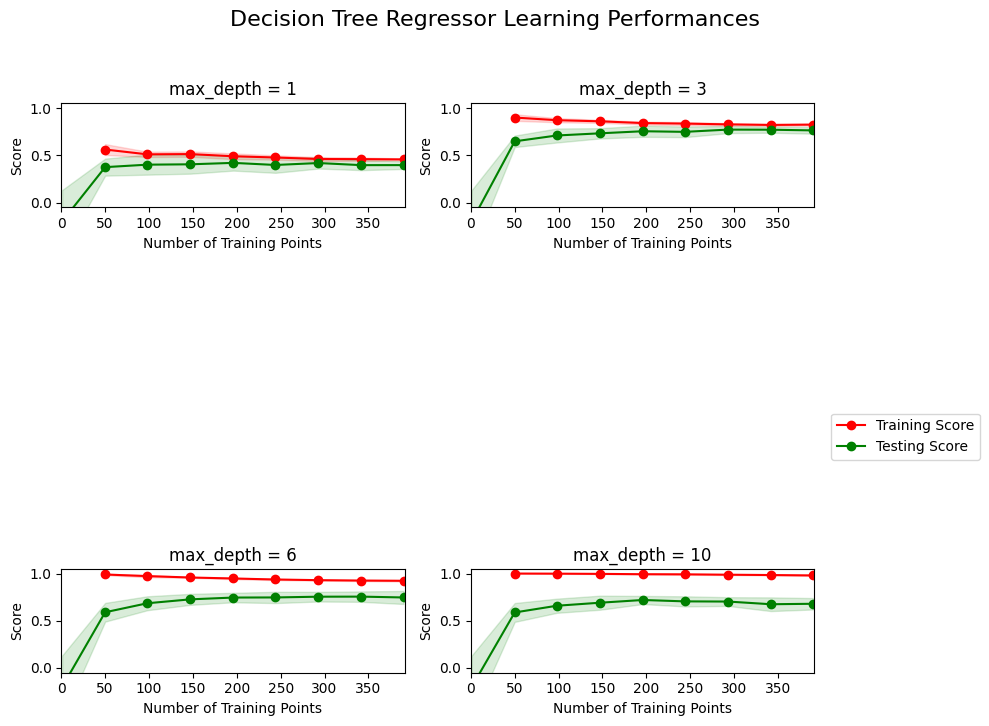

In [19]:
# Produce learning curves for varying training set sizes and maximum depths
ModelLearning(features, prices)

### Question 4 - Learning the Data
* Choose one of the graphs above and state the maximum depth for the model. 
* What happens to the score of the training curve as more training points are added? What about the testing curve? 
* Would having more training points benefit the model? 

**Hint:** Are the learning curves converging to particular scores? Generally speaking, the more data you have, the better. But if your training and testing curves are converging with a score above your benchmark threshold, would this be necessary?
Think about the pros and cons of adding more training points based on if the training and testing curves are converging.

**Answer: **

**Learning Curve - 1**

1. _Choose one of the graphs above and state the maximum depth for the model._ - 1
2. _What happens to the score of the training curve as more training points are added? What about the testing curve?_ - This case is more of an underfitting. Even if more data points are added the model will not learn new information and so the training score will be around 0.5. Also, as we have an underfit model, the score on the testing data will be less. Even if we add more testing data, the score will be around 0.5.
3. _Would having more training points benefit the model?_ - Having more training points will not help this model. Instead we should try to build a complex model to make a generalized understanding of the data.

**Learning Curve - 2**

1. _Choose one of the graphs above and state the maximum depth for the model._ - 3
2. _What happens to the score of the training curve as more training points are added? What about the testing curve?_ - This looks like the case of a very good model with a train and test score around 0.8. The model is perfecting the data to a greater extent. As more and more training data points are added, the training score decreases and finally hovers around 0.8. The testing score increases as the test data increases and finally plateau's around 0.8.
3. _Would having more training points benefit the model?_ - As the model is generalizing the data well, increasing the number of training data points will help it to learn better and give a better predictions.

**Learning Curve - 3**

1. _Choose one of the graphs above and state the maximum depth for the model._ - 6
2. _What happens to the score of the training curve as more training points are added? What about the testing curve?_ - This looks like the case of a slightly overfitted model. As more and more training data points are added, the training score decreases and finally hovers around 0.9. The testing score increases as the test data increases and finally plateau's around 0.75.
3. _Would having more training points benefit the model?_ - As the model is trying to overfit the data, increasing the number of training data points will not help it to generalize the information. Instead we should try to decrease the complexity of the model and then add more training data points for it to work better.

**Learning Curve - 4**

1. _Choose one of the graphs above and state the maximum depth for the model._ - 10
2. _What happens to the score of the training curve as more training points are added? What about the testing curve?_ - This looks like the case of an overfitted model. As more and more training data points are added, the training score decreases very slightly and finally hovers around 1. The testing score increases as the test data increases and finally plateau's around 0.6.
3. _Would having more training points benefit the model?_ - Adding more training points will not do any help for this model. Instead we should decrease the complexity of the model and try generalizing it.

### Complexity Curves
The following code cell produces a graph for a decision tree model that has been trained and validated on the training data using different maximum depths. The graph produces two complexity curves — one for training and one for validation. Similar to the **learning curves**, the shaded regions of both the complexity curves denote the uncertainty in those curves, and the model is scored on both the training and validation sets using the `performance_metric` function.  

** Run the code cell below and use this graph to answer the following two questions Q5 and Q6. **

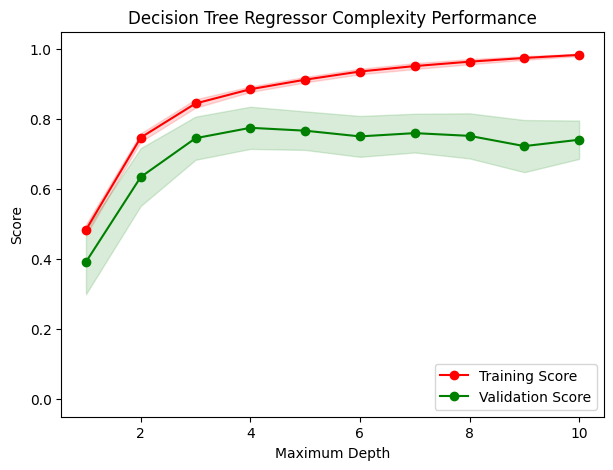

In [20]:
ModelComplexity(X_train, y_train)

### Question 5 - Bias-Variance Tradeoff
* When the model is trained with a maximum depth of 1, does the model suffer from high bias or from high variance? 
* How about when the model is trained with a maximum depth of 10? What visual cues in the graph justify your conclusions?

**Hint:** High bias is a sign of underfitting(model is not complex enough to pick up the nuances in the data) and high variance is a sign of overfitting(model is by-hearting the data and cannot generalize well). Think about which model(depth 1 or 10) aligns with which part of the tradeoff.

**Answer: **

1. _When the model is trained with a maximum depth of 1, does the model suffer from high bias or from high variance?_ - When we build a model with max_depth=1, the model is not trying to learn anything from the data and suffers from a very high Bias. The model cannot capture the variance in the data and cannot get a generalized meaning. The model that is built in this scenario will be an underfitted model. In this case we should try to increase the complexity of the model, say, by choosing a max_depth=5.

2. _How about when the model is trained with a maximum depth of 10?_ - When we build a model with max_depth=10, the model is trying to learn everything from the data(including noise!) and suffers from a very high Variance. The model cannot generalize the data and tries to learn each and every small thing, including noise, present in the data. The model that is built in this scenario will be an overfitted model. In this case we should try to decrease the complexity of the model, say, by choosing max_depth=5.

3. _What visual cues in the graph justify your conclusions?_ -

    1. From the Training/Testing Score visualization we say that a model is 'underfit' when the training score, testing/validation score is very less. This is seen from the above visualization when the max_depth=1.
    2. From the Training/Testing Score visualization we say that a model is 'overfit' when the training score, testing/validation score is very high but they diverge a lot. This is seen from the above visualization when the max_depth=10.
    
The ideal situation is when, both the training score and testing score are high and both of them converge very closely. From the above visualization, a max_depth=4 should get us a very good model.

### Question 6 - Best-Guess Optimal Model
* Which maximum depth do you think results in a model that best generalizes to unseen data? 
* What intuition lead you to this answer?

** Hint: ** Look at the graph above Question 5 and see where the validation scores lie for the various depths that have been assigned to the model. Does it get better with increased depth? At what point do we get our best validation score without overcomplicating our model? And remember, Occams Razor states "Among competing hypotheses, the one with the fewest assumptions should be selected."

**Answer: **

1. _Which maximum depth do you think results in a model that best generalizes to unseen data?_ - My personal choice goes with a max_depth of 3. At max_depth=3 the validation score is around 0.75, which is very good. The training score is around 0.85 and close to the validation score which hints us that the model is generalizing the data well. (We could also argue that max_depth=4 is a good choice. In this case the validation score is around 0.8 and the training score is around 0.9 which is good. This model is slightly overfitting the data compared to the model with max_depth=3.)

2. _What intuition lead you to this answer?_ - As can be seen clearly from the above visualization, a max_depth=1 creates a model with high bias, an underfitted model and a max_depth=10 creates a model with high variance, an overfitted model. We should choose a model that doesn't have high bias or a high variance - a model that generalizes the data well. Also the training and validation scores should not be very low(underfit) or very high(overfit) when building a model. Training and Validation scores should be high and very close to each other in a generalized model which is evident when we choose max_depth=3.

-----

## Evaluating Model Performance
In this final section of the project, you will construct a model and make a prediction on the client's feature set using an optimized model from `fit_model`.

### Question 7 - Grid Search
* What is the grid search technique?
* How it can be applied to optimize a learning algorithm?

** Hint: ** When explaining the Grid Search technique, be sure to touch upon why it is used,  what the 'grid' entails and what the end goal of this method is. To solidify your answer, you can also give an example of a parameter in a model that can be optimized using this approach.

**Answer: **

1. _What is the grid search technique?_ - Grid Search is a systematic way to tune the hyperparameters of an algorithm to build a best model. In machine learning, a hyperparameter is a parameter whose value is set before the learning process begins (ex. the degree of a polynomial in regression model). By contrast, the values of other parameters are derived via training (ex. the coefficients of the polynomial in regression model). 

2. _How it can be applied to optimize a learning algorithm?_ - Grid Search performs hyperparameter optimization by simply searching through a manually specified subset of the hyperparameter space of a learning algorithm. A grid search algorithm must be guided by some performance metric, typically measured by cross-validation on the training set or evaluation on a held-out validation set. The performance metric will help us to choose the best hyperparameter values to build a better model.

For example, if we are using DecisionTreeRegressor() we can pass the below hyperparameters to the Grid Search to find out the best combination.

params = {'max_depth': [2,3,4], 'max_features':['auto', 'sqrt', 'log2']}

Grid Search will try out all combinations of the above hyperparameters while building the models. We can use the cross-validation score to choose the best set of hyperparameters.

### Question 8 - Cross-Validation

* What is the k-fold cross-validation training technique? 
* What benefit does this technique provide for grid search when optimizing a model?

**Hint:** When explaining the k-fold cross validation technique, be sure to touch upon what 'k' is, how the dataset is split into different parts for training and testing and the number of times it is run based on the 'k' value.

When thinking about how k-fold cross validation helps grid search, think about the main drawbacks of grid search which are hinged upon **using a particular subset of data for training or testing** and how k-fold cv could help alleviate that. You can refer to the [docs](http://scikit-learn.org/stable/modules/cross_validation.html#cross-validation) for your answer.

**Answer: **

1. _What is the k-fold cross-validation training technique?_ - Instead of partitioning the data into multiple sets - training set and validation set, which drastically reduces the number of samples which can be used for learning the model we could use cross-validation to use the same data for better understanding of our mode's accuracy. k-fold cross-validation is one of the methods of CV where the original data is randomly partitioned into k equal sized subsamples. Out of the k subsamples, a single subsample is retained as the validation data for testing the model, and the remaining (k−1) subsamples are used as training data. The cross-validation process is repeated k times for each of the folds with each of the k subsamples used exactly once as the validation data. The 'k' scores from the folds can then be averaged to produce a single estimation.

2. _What benefit does this technique provide for grid search when optimizing a model?_ - With Grid Search we are trying to find the optimal hyperparameters for our model. For Grid Search to identify the best params we should use a score function and test the model on the validation set. If we choose a simple validation set by picking 30% of the data points, there is always a danger of not correctly choosing the best hyperparameters as there is a chance of overfitting/underfitting with specific train/test split and thus a wrong score. So, the ideal strategy is to choose a k-fold cross-validation technique wherein we could get an average score for each of the folds which would correctly get the optimal hyperparameters.

### Implementation: Fitting a Model
Your final implementation requires that you bring everything together and train a model using the **decision tree algorithm**. To ensure that you are producing an optimized model, you will train the model using the grid search technique to optimize the `'max_depth'` parameter for the decision tree. The `'max_depth'` parameter can be thought of as how many questions the decision tree algorithm is allowed to ask about the data before making a prediction. Decision trees are part of a class of algorithms called *supervised learning algorithms*.

In addition, you will find your implementation is using `ShuffleSplit()` for an alternative form of cross-validation (see the `'cv_sets'` variable). While it is not the K-Fold cross-validation technique you describe in **Question 8**, this type of cross-validation technique is just as useful!. The `ShuffleSplit()` implementation below will create 10 (`'n_splits'`) shuffled sets, and for each shuffle, 20% (`'test_size'`) of the data will be used as the *validation set*. While you're working on your implementation, think about the contrasts and similarities it has to the K-fold cross-validation technique.

Please note that ShuffleSplit has different parameters in scikit-learn versions 0.17 and 0.18.
For the `fit_model` function in the code cell below, you will need to implement the following:
- Use [`DecisionTreeRegressor`](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html) from `sklearn.tree` to create a decision tree regressor object.
  - Assign this object to the `'regressor'` variable.
- Create a dictionary for `'max_depth'` with the values from 1 to 10, and assign this to the `'params'` variable.
- Use [`make_scorer`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html) from `sklearn.metrics` to create a scoring function object.
  - Pass the `performance_metric` function as a parameter to the object.
  - Assign this scoring function to the `'scoring_fnc'` variable.
- Use [`GridSearchCV`](http://scikit-learn.org/0.17/modules/generated/sklearn.grid_search.GridSearchCV.html) from `sklearn.grid_search` to create a grid search object.
  - Pass the variables `'regressor'`, `'params'`, `'scoring_fnc'`, and `'cv_sets'` as parameters to the object. 
  - Assign the `GridSearchCV` object to the `'grid'` variable.

In [21]:
def fit_model(X, y):
    """ Performs grid search over the 'max_depth' parameter for a 
        decision tree regressor trained on the input data [X, y]. """
    
    # Create cross-validation sets from the training data
    # sklearn version 0.18: ShuffleSplit(n_splits=10, test_size=0.1, train_size=None, random_state=None)
    # sklearn versiin 0.17: ShuffleSplit(n, n_iter=10, test_size=0.1, train_size=None, random_state=None)
    cv_sets = ShuffleSplit(n_splits = 10, test_size = 0.20, random_state = 0)
    cv_sets.get_n_splits(X)

    # Create a decision tree regressor object
    regressor = DecisionTreeRegressor(random_state=0)

    # Create a dictionary for the parameter 'max_depth' with a range from 1 to 10
    params = {'max_depth':range(1,11)}

    # Transform 'performance_metric' into a scoring function using 'make_scorer' 
    scoring_fnc = make_scorer(performance_metric)

    # Create the grid search cv object --> GridSearchCV()
    # Make sure to include the right parameters in the object:
    # (estimator, param_grid, scoring, cv) which have values 'regressor', 'params', 'scoring_fnc', and 'cv_sets' respectively.
    grid = GridSearchCV(regressor, params, scoring_fnc, cv=cv_sets)

    # Fit the grid search object to the data to compute the optimal model
    grid = grid.fit(X, y)

    # Return the optimal model after fitting the data
    return grid

### Making Predictions
Once a model has been trained on a given set of data, it can now be used to make predictions on new sets of input data. In the case of a *decision tree regressor*, the model has learned *what the best questions to ask about the input data are*, and can respond with a prediction for the **target variable**. You can use these predictions to gain information about data where the value of the target variable is unknown — such as data the model was not trained on.

### Question 9 - Optimal Model

* What maximum depth does the optimal model have? How does this result compare to your guess in **Question 6**?  

Run the code block below to fit the decision tree regressor to the training data and produce an optimal model.

In [22]:
# Fit the training data to the model using grid search
reg = fit_model(X_train, y_train)

# Produce the value for 'max_depth'
print("Parameter 'max_depth' is {} for the optimal model.".format(reg.best_estimator_.get_params()['max_depth']))
print("Best Score is {:.2f}".format(reg.best_score_))

TypeError: GridSearchCV.__init__() takes 3 positional arguments but 4 positional arguments (and 1 keyword-only argument) were given

** Hint: ** The answer comes from the output of the code snipped above.

**Answer: **

The optimal score of '0.78' is achieved for a max_depth of 4. As was mentioned above there is a close call score for max_depth=4 and max_depth=3. (We got a score of 0.75 for max_depth=3)

### Question 10 - Predicting Selling Prices
Imagine that you were a real estate agent in the Boston area looking to use this model to help price homes owned by your clients that they wish to sell. You have collected the following information from three of your clients:

| Feature | Client 1 | Client 2 | Client 3 |
| :---: | :---: | :---: | :---: |
| Total number of rooms in home | 5 rooms | 4 rooms | 8 rooms |
| Neighborhood poverty level (as %) | 17% | 32% | 3% |
| Student-teacher ratio of nearby schools | 15-to-1 | 22-to-1 | 12-to-1 |

* What price would you recommend each client sell his/her home at? 
* Do these prices seem reasonable given the values for the respective features? 

**Hint:** Use the statistics you calculated in the **Data Exploration** section to help justify your response.  Of the three clients, client 3 has has the biggest house, in the best public school neighborhood with the lowest poverty level; while client 2 has the smallest house, in a neighborhood with a relatively high poverty rate and not the best public schools.

Run the code block below to have your optimized model make predictions for each client's home.

In [ ]:
with pd.option_context('float_format', '{:.2f}'.format):
    print(prices.describe())

In [ ]:
with pd.option_context('float_format', '{:.2f}'.format):
    print(features.describe())

**Answer: **

1. _What price would you recommend each client sell his/her home at?_ - With the statistical information we could ask Client 1 to sell his house at a price around the mean (USD 454,342 $\pm$ 0.5$\sigma$), Client 2 to sell his house at a price little higher than the min price (USD 150,000 $\pm$ 0.5$\sigma$) and Client 3 to sell his house at a price around the max (USD 900,000 $\pm$ 0.5$\sigma$).
2. _Do these prices seem reasonable given the values for the respective features?_ - Yes, these prices seems reasonable. For example Client 2 has just 4 rooms, high neighborhood poverty level and high PTRATIO which indicates a low value for his house. On the other hand, Client 3 has 8 rooms, very low neighborhood poverty level and very low PTRATIO which indicates a high value for his house.

In [ ]:
# Produce a matrix for client data
client_data = [[5, 17, 15], # Client 1
               [4, 32, 22], # Client 2
               [8, 3, 12]]  # Client 3

# Show predictions
for i, price in enumerate(reg.predict(client_data)):
    print("Predicted selling price for Client {}'s home: ${:,.2f}".format(i+1, price))

**Answer: **

1. _What price would you recommend each client sell his/her home at?_ - With the predictions from the model, which is around 80% accurate, we could ask Client 1 to sell his house at a price around (USD 350,000 to USD 430,000), Client 2 to sell his house at a price around (USD 160,000 - USD 220,000) and Client 3 to sell his house at a price around (USD 910,000 - USD 980,000).
2. _Do these prices seem reasonable given the values for the respective features?_ - Yes, these prices seems reasonable. For example Client 2 has just 4 rooms, high neighborhood poverty level and high PTRATIO which indicates a low value for his house. On the other hand, Client 3 has 8 rooms, very low neighborhood poverty level and very low PTRATIO which indicates a high value for his house. For Cleint 1 the values for all the features are centered around the mean and thus an avergae price for his house.

### Sensitivity
An optimal model is not necessarily a robust model. Sometimes, a model is either too complex or too simple to sufficiently generalize to new data. Sometimes, a model could use a learning algorithm that is not appropriate for the structure of the data given. Other times, the data itself could be too noisy or contain too few samples to allow a model to adequately capture the target variable — i.e., the model is underfitted. 

**Run the code cell below to run the `fit_model` function ten times with different training and testing sets to see how the prediction for a specific client changes with respect to the data it's trained on.**

In [ ]:
PredictTrials(features, prices, fit_model, client_data)

### Question 11 - Applicability

* In a few sentences, discuss whether the constructed model should or should not be used in a real-world setting.  

**Hint:** Take a look at the range in prices as calculated in the code snippet above. Some questions to answering:
- How relevant today is data that was collected from 1978? How important is inflation?
- Are the features present in the data sufficient to describe a home? Do you think factors like quality of apppliances in the home, square feet of the plot area, presence of pool or not etc should factor in?
- Is the model robust enough to make consistent predictions?
- Would data collected in an urban city like Boston be applicable in a rural city?
- Is it fair to judge the price of an individual home based on the characteristics of the entire neighborhood?

**Answer: **

To know if the constructed model can be used in a real-world applications depends on many factors.

1. As the data is collected from 1978, the information may not portray the current trend in the locality even though inflation is taken in to account.
2. Frankly speaking we cannot exactly predict the price of a house using just 3 independent variables. There are many more factors like the 'Building Type', 'Quality of Construction', 'Year Built', 'Bathrooms', 'Kitchen Quality', 'Garages', 'Pool', 'Fence' which will give us a better estimate of any house.
3. As the model is built on a very less number of features and some data points it will not be very robust. So, when using the predictions from this model care should be taken to consider other external factors also. (Robustness of the model was evident from the above block of code.)
4. This model is built from data collected in 'Boston' and so can be used to predict the prices of houses in 'Boston' only and the reason being different cities will have different price ranges of houses.
5. It's not fair to judge the price of an individual house just based on the neighborhood. Many properties of the house play a vital role in predicted its price aprt from it's neighborhood.